<a href="https://colab.research.google.com/github/angelotc/FriedmanIsolationForest/blob/main/FriedmanIsoForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
from sklearn.datasets import make_friedman1
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import model_selection 
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt


In [152]:
# Helper functions

def add_y_as_feature(X,y):
    X['y1']=y
    return X

def contaminate_df(df1, df2, percentage):
    '''
    Assumes df1 and df2 have the same number of samples.
    Parameters:
    df1 (df) - dataframe to contaminate
    df2  (df) - dataframe that is contaminated (has noise)
    percentage (float) - Percentage in the form of a float (0,1) . It will add remove this percentage of rows from df1, and add this percentage of the contaminated rows from df2 into df1. 
    For example, if float = 0.05, it will remove the last 5% of the rows in df1, and add the first 5% of the rows from df2 into df1 and return that modified dataframe as the first dataframe.
    The second dataframe that it returns are the samples from df2 that were not added to df1.
    
    Returns:
    two dataframes:
    - modified df1 with contaminated samples
    - the samples from df2 that were not added to df1 (we will save this to use as a training set)
    '''
    assert(len(y1) == len(y2)), "y1 needs to be the same length as y2"
    return y1[:int(len(y1)*(1-percentage))].append(y2[:int(len(y2)*percentage)]), y2[int(len(y2)*percentage):]


In [153]:
# Create synthetic dataset using make_friedman1. N = 100k

X1, y1 = make_friedman1(
    n_samples=10000, n_features = 5 , random_state=1)


# Create another synthetic dataset with noise.
X2, y2 = make_friedman1(
    n_samples=10000, n_features = 5, random_state=1, noise=20)

y2 += 30

x_cols = ["x1", "x2", "x3", "x4", "x5"]

In [159]:
# Convert from numpy arrays to pandas dataframes
X1 = pd.DataFrame(X1, columns = ["x1", "x2", "x3", "x4", "x5"])
y1 = pd.DataFrame(y1, columns = ["y1"])
X2 = pd.DataFrame(X2, columns = ["x1", "x2", "x3", "x4", "x5"])
y2 = pd.DataFrame(y2, columns = ["y1"])

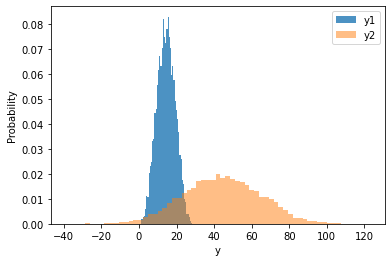

In [160]:
from matplotlib import pyplot as plt
# n_bins = len(X)//100
# We can set the number of bins with the `bins` kwarg

plt.xlabel('y')
plt.ylabel('Probability')

# bins = compute_histogram_bins(y1, 1.0)
plt.hist(y1, bins='auto', alpha=0.8, density = True, label='y1')
plt.hist(y2, bins='auto', alpha=0.5, density = True, label='y2')
plt.legend(loc='upper right')
plt.show()


In [156]:
# df1 = add_y_as_feature(X1,y1)
# df2 = add_y_as_feature(X2,y2)
# df1.head(), df2.head()

In [161]:
modified_y1, test_y2 = contaminate_y(df1, df2, 0.05)

In [162]:
# Instantiate model -> fit -> predict using test set.
# Note on contamination parameter: This is a parameter that the algorithm is quite sensitive to; it refers to the expected 
# proportion of outliers in the data set. This is used when fitting to define the threshold on the scores of the samples.

clf = IsolationForest(max_samples=0.5, contamination = 0.05, bootstrap = False )
clf.fit(y1)
y_pred_test = pd.DataFrame(clf.predict(test_y2))

In [163]:
y_pred_test.value_counts()

-1    8284
 1    1216
dtype: int64

y(X) = 10 * sin(pi * X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 + 10 * X[:, 3] + 5 * X[:, 4] + noise * N(0, 1).

##Everything below is experimental:

In [ ]:
# Increasing features from 5->50? Only first 5 variables are correlated, so what if we add more independent variables. Would that change our predictions?
for i in range (5,10):
  X, y = make_friedman1(
    n_samples=100000, n_features = i,  noise=0.1, random_state=1)
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1, random_state=42)
  clf = IsolationForest(max_samples='auto', contamination = 0)
  clf.fit(X_train)
  y_pred_test = clf.predict(X_test)
  print(i, pd.DataFrame(y_pred_test).value_counts())

In [ ]:
# Doesn't look like it!